In [389]:
import pandas as pd
import numpy as np
#print('PyCaret: %s' % pycaret.__version__)
import matplotlib.pyplot as plt

In [390]:
df_main = pd.read_csv('df_train_data_with_price.csv').set_index('Unnamed: 0')
#Shape : 11333,65
df_main.shape

(8095, 254)

In [391]:
df_main.head(4)

,Tikr_x,Sales_yr_1,Sales_yr_2,Sales_yr_3,Sales_yr_4,Sales_yr_5,Sales_yr_2_YoY,Sales_yr_3_YoY,Sales_yr_4_YoY,Sales_yr_5_YoY,...,Trend_lag_08,Trend_lag_09,Trend_lag_10,Trend_lag_11,Trend_lag_12,Return,Year,Tikr_y,Nifty_Returns,Return_adj
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,20MICRONS,175.00,234.00,262.00,275.00,288.00,33.71,11.97,4.96,4.73,...,-2.15,-0.13,-3.18,-0.69,-0.81,30.12,2015,Nift,15.84,14.28
1,21STCENMGM,1.18,23.45,-4.20,0.12,1.08,"1,887.29",-117.91,-102.86,800.00,...,nan,nan,nan,nan,nan,nan,2015,Nift,15.84,nan
2,3IINFOTECH,692.00,963.00,"1,120.00","1,198.00","1,278.00",39.16,16.30,6.96,6.68,...,nan,nan,nan,nan,nan,nan,2015,Nift,15.84,nan
3,3MINDIA,"1,087.00","1,191.00","1,405.00","1,574.00","1,742.00",9.57,17.97,12.03,10.67,...,17.39,10.29,-2.99,5.47,-0.21,46.43,2015,Nift,15.84,30.59


In [392]:
# Removing rows containing nans
df_main = df_main[df_main['Return'].notna()]
df_main.shape
#8436,65
df_main.replace([np.inf, -np.inf], 0, inplace=True)
df_main.fillna(0, inplace=True)

df_main['Return_class'] = np.where(df_main['Return_adj'] > 0,1,0)
df_main['Corona_Yr'] = np.where(df_main['Year'] == 2020,1,0)

In [393]:
import pickle
# Save to file in the current working directory
pkl_rf_model = ".\\Model\\rf_model.pkl"
pkl_xgb_model = ".\\Model\\xgb_model.pkl"
pkl_lgb_model = ".\\Model\\lgb_model.pkl"

#Importing models
rf_model = pickle.load(open(pkl_rf_model, 'rb'))    
xgb_model = pickle.load(open(pkl_xgb_model, 'rb'))
lgb_model = pickle.load(open(pkl_lgb_model, 'rb'))

In [394]:
To_Valiate = 2020
start_date = '2020-1-1'
end_date = '2022-12-31'
# Keeping 2018 data reserved for validation
df_validation_copy = df_main[(df_main['Year'] == To_Valiate)]
df_validation = df_main[(df_main['Year'] == To_Valiate)]
df_validation = df_validation.drop(['Return_adj','Return','Tikr_x','Tikr_y','Nifty_Returns','Return_class'],axis=1)

In [395]:
lgb_valid_preds = lgb_model.predict_proba(df_validation)[:,1]
xgb_valid_preds = xgb_model.predict_proba(df_validation)[:,1]
rf_valid_preds = rf_model.predict_proba(df_validation)[:,1]
lgb_y_valid = lgb_model.predict(df_validation)
xgb_y_valid = xgb_model.predict(df_validation)
rf_y_valid = rf_model.predict(df_validation)

pred_list = pd.DataFrame(
    {'lgb_score': lgb_valid_preds,
     'xgb_score': xgb_valid_preds,
     'rf_score': rf_valid_preds,
     'lgb_label': lgb_y_valid,
     'xgb_label': xgb_y_valid,
     'rf_label': rf_y_valid,
    })
pred_list

ValueError: Input data must be 2 dimensional and non empty.

In [ ]:
# bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# labels = ["Bin 1-10","Bin 11-20","Bin 21-30","Bin 31-40","Bin 41-50","Bin 51-60","Bin 61-70","Bin 71-80","Bin 81-90","Bin 91-100"]
bins = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
labels = ["Bin 1-5","Bin 6-10","Bin 11-15","Bin 16-20","Bin 21-25","Bin 26-30","Bin 31-35","Bin 36-40","Bin 41-45","Bin 46-50","Bin 51-55","Bin 56-60","Bin 61-65","Bin 66-70","Bin 71-75","Bin 76-80",
            "Bin 81-85","Bin 86-90","Bin 91-95","Bin 96-100"]

pred_list['RandomForest_Bucket'] = pd.cut(pred_list['rf_score'], bins, labels = labels,include_lowest = True)
pred_list['XgBoost_Bucket'] = pd.cut(pred_list['xgb_score'], bins, labels = labels,include_lowest = True)
pred_list['LGBM_Bucket'] = pd.cut(pred_list['lgb_score'], bins, labels = labels,include_lowest = True)

pred_list['rf_decile'] = pd.qcut(pred_list['rf_score'], 20, labels=False, duplicates='drop')+1
pred_list['lgb_decile'] = pd.qcut(pred_list['lgb_score'], 20, labels=False, duplicates='drop')+1
pred_list['xgb_decile'] = pd.qcut(pred_list['xgb_score'], 20, labels=False, duplicates='drop')+1

pred_list['rf_decile'] = 'Decile_' + pred_list['rf_decile'].astype(str).str.pad(2,fillchar='0')
pred_list['lgb_decile'] = 'Decile_' + pred_list['lgb_decile'].astype(str).str.pad(2,fillchar='0')
pred_list['xgb_decile'] = 'Decile_' + pred_list['xgb_decile'].astype(str).str.pad(2,fillchar='0')
pred_list

# Performance Based Decile
df_main['Return'] = df_main['Return'].astype(float)

# Replacing outliers with Max below outliers
df_main['Return_AD'] = df_main['Return']
median = df_main['Return'].median()
std = df_main['Return'].std()
outliers = (df_main['Return'] - median).abs() > (5 * std)
replacement = df_main['Return'][outliers].min()
df_main['Return_AD'][outliers] = replacement

df_main['Return_Norm'] = df_main[['Return_AD']].apply(lambda x: x/x.max())
#df_main['Return_Norm'] = (df_main['Return'] - df_main['Return'].min()) / (df_main['Return'].max() - df_main['Return'].min())
df_main['Performance_decile'] = pd.qcut(df_main['Return_Norm'], 30, labels=False, duplicates='drop')+1
df_main['Performance_decile'] = 'Decile_' + df_main['Performance_decile'].astype(str).str.pad(2,fillchar='0')
df_main['Performance_Bucket'] = pd.cut(df_main['Return_Norm'], bins, labels = labels,include_lowest = True)

C:\Users\hashmy\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


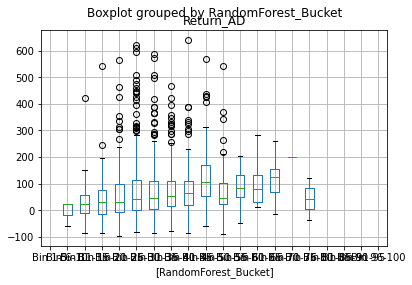

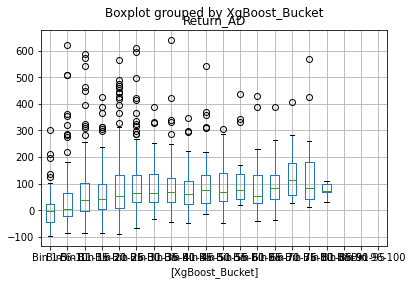

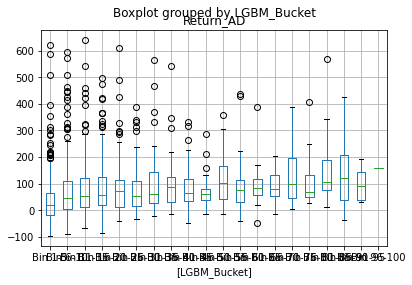

In [ ]:
df_valid_out = pd.concat([df_validation_copy.reset_index(drop=True), pred_list], axis=1)

cols = ['Return'] # one or more

Q1 = df_valid_out['Return'].quantile(0.25)
Q3 = df_valid_out['Return'].quantile(0.75)
IQR = Q3 - Q1

#df_valid_out['Return'] < (Q1 - 4 * IQR))

df_valid_out['Return_AD'] = df_valid_out['Return'].mean()
df_valid_out['Return_AD'] = df_valid_out['Return'][~((df_valid_out[cols] < (Q1 - 5 * IQR)) |(df_valid_out[cols] > (Q3 + 5 * IQR))).any(axis=1)]

boxplot = df_valid_out.boxplot(column=['Return_AD'], by=['RandomForest_Bucket'],layout=(1, 1))
boxplot = df_valid_out.boxplot(column=['Return_AD'], by=['XgBoost_Bucket'])
boxplot = df_valid_out.boxplot(column=['Return_AD'], by=['LGBM_Bucket'])

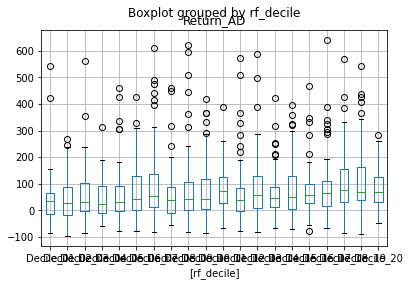

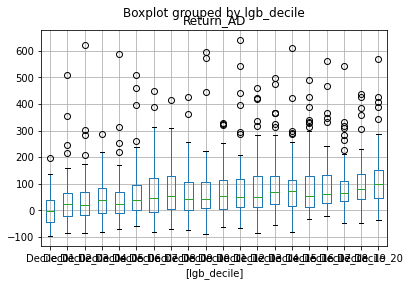

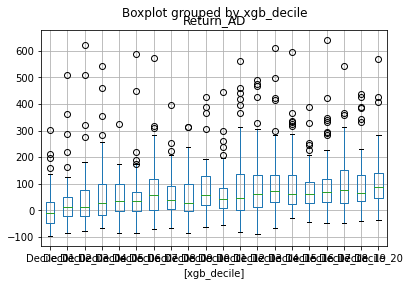

In [ ]:
boxplot = df_valid_out.boxplot(column=['Return_AD'], by=['rf_decile'],layout=(1, 1))
boxplot = df_valid_out.boxplot(column=['Return_AD'], by=['lgb_decile'])
boxplot = df_valid_out.boxplot(column=['Return_AD'], by=['xgb_decile'])

## With deciles the results are better concentrated in top deciles


#Validating Results using Market return

In [ ]:
import pandas as pd
import numpy as np
import re
import yfinance as yf
import datetime
# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%matplotlib inline

In [ ]:
df_analysis = df_valid_out.copy()

# Normalizing the scores between 0 and 1
df_analysis[['lgb_score','xgb_score','rf_score']] = df_analysis[['lgb_score','xgb_score','rf_score']].apply(lambda x: x/x.max(), axis=0)

df_analysis['Avg_Score'] = df_analysis[['lgb_score','xgb_score','rf_score']].mean(axis=1)
df_analysis[['lgb_score','xgb_score','rf_score','Avg_Score']].head()

,lgb_score,xgb_score,rf_score,Avg_Score
0,0.04,0.17,0.18,0.13
1,0.02,0.05,0.39,0.15
2,0.88,0.83,0.54,0.75
3,0.09,0.16,0.35,0.20
4,0.09,0.25,0.54,0.29


<AxesSubplot:xlabel='Return_AD', ylabel='Avg_Score'>

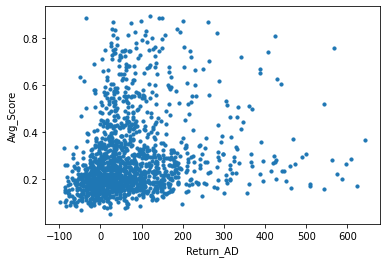

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_analysis.plot(kind='scatter', x='Return_AD', y='Avg_Score', s=10)

In [ ]:
#Recreating bins on Averaged scores
bins = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
labels = ["Bin 1-5","Bin 6-10","Bin 11-15","Bin 16-20","Bin 21-25","Bin 26-30","Bin 31-35","Bin 36-40","Bin 41-45","Bin 46-50","Bin 51-55","Bin 56-60","Bin 61-65","Bin 66-70","Bin 71-75","Bin 76-80",
            "Bin 81-85","Bin 86-90","Bin 91-95","Bin 96-100"]
df_analysis['Main_decile'] = pd.qcut(df_analysis['Avg_Score'], 30, labels=False)+1
df_analysis['Main_decile'] = 'Decile_' + df_analysis['Main_decile'].astype(str).str.pad(2,fillchar='0')
df_analysis['Main_Bucket'] = pd.cut(df_analysis['Avg_Score'], bins, labels = labels,include_lowest = True)

# Performance Based Decile
#df_analysis['Return_Norm'] = (df_analysis['Return_AD'] - df_analysis['Return'].min()) / (df_analysis['Return'].max() - df_analysis['Return'].min())
df_analysis['Performance_decile'] = pd.qcut(df_analysis['Return'], 30, labels=False)+1
df_analysis['Performance_decile'] = 'Decile_' + df_analysis['Performance_decile'].astype(str).str.pad(2,fillchar='0')
df_analysis['Performance_Bucket'] = pd.cut(df_analysis['Return'], bins, labels = labels,include_lowest = True)


In [ ]:
#df_analysis['Main_Bucket'].value_counts()
df_analysis.to_clipboard()
df_analysis = df_analysis.sort_values('Avg_Score', ascending=False)
df_analysis['Performance_decile'].value_counts()
df_analysis
# There are approx 100 shares in top 3 buckets

,Tikr_x,Sales_yr_1,Sales_yr_2,Sales_yr_3,Sales_yr_4,Sales_yr_5,Sales_yr_2_YoY,Sales_yr_3_YoY,Sales_yr_4_YoY,Sales_yr_5_YoY,...,LGBM_Bucket,rf_decile,lgb_decile,xgb_decile,Return_AD,Avg_Score,Main_decile,Main_Bucket,Performance_decile,Performance_Bucket
408,FLUOROCHEM,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,Bin 86-90,Decile_20,Decile_20,Decile_20,121.73,0.89,Decile_30,Bin 86-90,Decile_24,NaN
1095,RELAXO,"1,180.00","1,441.00","1,668.00","1,631.00","1,941.00",22.12,15.75,-2.22,19.01,...,Bin 91-95,Decile_20,Decile_20,Decile_20,141.48,0.89,Decile_30,Bin 86-90,Decile_25,NaN
695,JUBLFOOD,"1,724.00","2,074.00","2,410.00","2,546.00","2,980.00",20.30,16.20,5.64,17.05,...,Bin 91-95,Decile_20,Decile_20,Decile_20,150.41,0.89,Decile_30,Bin 86-90,Decile_25,NaN
1301,SWSOLAR,0.00,0.00,0.00,0.00,"6,126.00",0.00,0.00,0.00,0.00,...,Bin 86-90,Decile_20,Decile_20,Decile_20,-35.87,0.89,Decile_30,Bin 86-90,Decile_03,NaN
1290,SUPREMEIND,"3,961.00","4,253.00","2,960.00","4,461.00","4,969.00",7.37,-30.40,50.71,11.39,...,Bin 91-95,Decile_20,Decile_20,Decile_20,99.53,0.88,Decile_30,Bin 86-90,Decile_22,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,BHARATGEAR,420.00,415.00,398.00,407.00,508.00,-1.19,-4.10,2.26,24.82,...,Bin 1-5,Decile_01,Decile_01,Decile_01,9.18,0.08,Decile_01,Bin 6-10,Decile_09,NaN
9,AARVEEDEN,685.00,746.00,841.00,844.00,827.00,8.91,12.73,0.36,-2.01,...,Bin 1-5,Decile_01,Decile_01,Decile_02,16.07,0.08,Decile_01,Bin 6-10,Decile_10,NaN
662,JBFIND,"4,785.00","4,127.00","3,618.00","3,913.00","3,501.00",-13.75,-12.33,8.15,-10.53,...,Bin 1-5,Decile_01,Decile_01,Decile_01,59.64,0.08,Decile_01,Bin 6-10,Decile_17,NaN
226,CANDC,"1,283.00","1,013.00",767.00,949.00,943.00,-21.04,-24.28,23.73,-0.63,...,Bin 1-5,Decile_01,Decile_01,Decile_01,-48.15,0.07,Decile_01,Bin 6-10,Decile_02,NaN


<AxesSubplot:xlabel='None-Performance_decile', ylabel='Main_decile'>

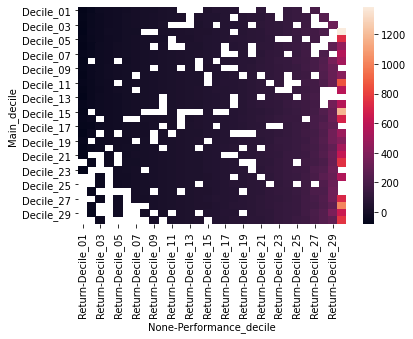

In [ ]:
# What is the distribution of Performance decile in Main Decile, 
# How many top performing stocks were part of 

df_heatmap_count = pd.pivot_table(df_analysis, index=['Main_decile'], columns=['Performance_decile'], values=['Return'], aggfunc='count')
df_heatmap_avg = pd.pivot_table(df_analysis, index=['Main_decile'], columns=['Performance_decile'], values=['Return'], aggfunc='mean')
df_heatmap_sum = pd.pivot_table(df_analysis, index=['Main_decile'], columns=['Performance_decile'], values=['Return'], aggfunc='sum')
sns.heatmap(df_heatmap_avg, annot=False)

In [ ]:
df_heatmap_sum

Return                                          \
Performance_decile Decile_01 Decile_02 Decile_03 Decile_04 Decile_05   
Main_decile                                                            
Decile_01            -802.41   -144.00   -144.22    -62.16    -60.59   
Decile_02            -273.29   -188.45   -129.89    -40.79    -41.51   
Decile_03            -213.15   -184.11   -127.17    -84.59    -45.35   
Decile_04            -244.30    -80.46    -32.54    -54.10    -13.97   
Decile_05            -209.53    -91.41    -35.47   -109.66    -60.27   
Decile_06            -142.97    -51.26   -176.50    -66.21    -23.31   
Decile_07             -58.73   -256.20    -58.63    -42.10    -24.50   
Decile_08            -205.61       nan    -27.56    -68.95       nan   
Decile_09            -124.15    -83.58    -60.37    -34.70    -11.04   
Decile_10            -265.03    -83.43    -56.47    -17.31    -39.57   
Decile_11             -54.34    -45.16   -151.21    -45.50       nan   
Decile_12             -69.68   -127.40    -61.98    -20.58    -12.00   
Decile_13             -82.07   -219.62    -30.01    -20.01    -14.52   
Decile_14             -54.37   -164.18    -58.20    -21.01    -29.50   
Decile_15             -69.21       nan    -60.33    -40.30    -67.89   
Decile_16             -54.06    -36.90       nan    -42.46    -60.29   
Decile_17             -61.40   -107.37    -90.80    -38.03    -28.16   
Decile_18            -231.64   -120.26       nan    -60.47       nan   
Decile_19             -56.38       nan    -25.42    -40.50    -10.76   
Decile_20             -65.46    -42.45    -25.74       nan    -13.07   
Decile_21             -66.87       nan       nan    -86.91       nan   
Decile_22                nan    -43.13       nan    -41.80       nan   
Decile_23            -147.80       nan       nan       nan    -25.76   
Decile_24                nan       nan    -61.48       nan    -22.55   
Decile_25                nan       nan    -32.12       nan    -14.52   
Decile_26                nan    -47.45       nan       nan       nan   
Decile_27                nan       nan    -35.38       nan    -13.54   
Decile_28                nan    -39.78       nan       nan    -41.84   
Decile_29                nan    -49.63       nan       nan    -15.92   
Decile_30                nan       nan    -35.87       nan       nan   

                                                                      ...  \
Performance_decile Decile_06 Decile_07 Decile_08 Decile_09 Decile_10  ...   
Main_decile                                                           ...   
Decile_01              -7.68     -3.39     13.06      9.18     50.65  ...   
Decile_02             -36.51      2.49      5.76     26.57     19.12  ...   
Decile_03             -10.52     -4.33     13.66     50.66     21.28  ...   
Decile_04             -37.27     -4.27       nan       nan     87.93  ...   
Decile_05              -6.42     -1.37      6.33     14.40     15.30  ...   
Decile_06              -6.68      0.98      5.30       nan     17.21  ...   
Decile_07             -29.33     -2.43     10.54      9.90     20.99  ...   
Decile_08              -9.72      0.41      6.21     13.68     56.27  ...   
Decile_09              -8.88      1.96     34.21       nan     49.79  ...   
Decile_10             -29.04       nan     15.71     36.24     16.10  ...   
Decile_11             -13.97      1.84     14.83     60.26     35.89  ...   
Decile_12              -3.67       nan     11.95     24.11     62.46  ...   
Decile_13              -6.83     -3.51     27.68     43.41       nan  ...   
Decile_14              -5.85     -0.76      7.93     40.65       nan  ...   
Decile_15             -32.15     -1.66       nan       nan       nan  ...   
Decile_16                nan       nan      6.95     20.88     33.49  ...   
Decile_17             -11.24      2.03      3.41     24.24       nan  ...   
Decile_18             -10.46     -2.10      3.34       nan     38.22  ...   
Decile_19              -9.86

In [ ]:
# Lets pick up top 3 buckets and crete portfolio out of it
#selected_tikrs = df_analysis['Tikr_x'][df_analysis['Main_Bucket'].isin(['Bin 91-100','Bin 81-90','Bin 71-80'])].to_list()
# # Bins based filtering
# selected_tikrs = df_analysis['Tikr_x'][df_analysis['Main_Bucket'].isin(['Bin 91-100','Bin 81-90'])].to_list()
# DEcile based filtering
#selected_tikrs = df_analysis['Tikr_x'][df_analysis['Main_decile'].isin(['Decile_10'])].to_list()
selected_tikrs = df_analysis['Tikr_x'][df_analysis['Main_decile'].isin(['Decile_30','Decile_29','Decile_28','Decile_27','Decile_26','Decile_25'])].to_list()
selected_tikrs = [s + '.NS' for s in selected_tikrs]
selected_tikrs.append('^NSEI')
pd.DataFrame(selected_tikrs).to_clipboard()
selected_tikrs

['FLUOROCHEM.NS',
 'RELAXO.NS',
 'JUBLFOOD.NS',
 'SWSOLAR.NS',
 'SUPREMEIND.NS',
 'KPITTECH.NS',
 'SOLARA.NS',
 'ADANIGREEN.NS',
 'PGHH.NS',
 'BAJAJFINSV.NS',
 'APOLLOHOSP.NS',
 'COLPAL.NS',
 'HDFCAMC.NS',
 'BERGEPAINT.NS',
 'BAJFINANCE.NS',
 'TATACONSUM.NS',
 'MINDTREE.NS',
 'HDFC.NS',
 'PIDILITIND.NS',
 'TRENT.NS',
 'NAUKRI.NS',
 'ADANITRANS.NS',
 'MARICO.NS',
 'ATUL.NS',
 'ASTRAL.NS',
 'FINEORG.NS',
 'AARTIIND.NS',
 'KOTAKBANK.NS',
 'VBL.NS',
 'BIOCON.NS',
 'JCHAC.NS',
 'DMART.NS',
 'LTI.NS',
 'CROMPTON.NS',
 'LUXIND.NS',
 'DEEPAKNTR.NS',
 'IPCALAB.NS',
 'DABUR.NS',
 '3MINDIA.NS',
 'HDFCBANK.NS',
 'INFY.NS',
 'NAM-INDIA.NS',
 'PAGEIND.NS',
 'IGL.NS',
 'PIIND.NS',
 'HONAUT.NS',
 'PFIZER.NS',
 'LAURUSLABS.NS',
 'JKCEMENT.NS',
 'VAIBHAVGBL.NS',
 'DIXON.NS',
 'HINDUNILVR.NS',
 'WHIRLPOOL.NS',
 'BRITANNIA.NS',
 'ORIENTELEC.NS',
 'AEGISCHEM.NS',
 'EMAMILTD.NS',
 'METROPOLIS.NS',
 'SANOFI.NS',
 'ZYDUSWELL.NS',
 'IRCTC.NS',
 'POLYMED.NS',
 'ALKYLAMINE.NS',
 'SYNGENE.NS',
 'KANSAINER.NS',
 '

In [ ]:
df_trend = yf.download(selected_tikrs,start = start_date, end = end_date)['Adj Close']
df_trend = df_trend[pd.to_datetime(df_trend.index) < pd.to_datetime(end_date)]
df_trend

[*********************100%***********************]  302 of 302 completed


,3MINDIA.NS,AARTIDRUGS.NS,AARTIIND.NS,AAVAS.NS,ABFRL.NS,ADANIGREEN.NS,ADANIPORTS.NS,ADANITRANS.NS,ADFFOODS.NS,ADVENZYMES.NS,...,VMART.NS,VOLTAS.NS,VSTIND.NS,WABCOINDIA.NS,WHIRLPOOL.NS,WIPRO.NS,WOCKPHARMA.NS,ZENSARTECH.NS,ZYDUSWELL.NS,^NSEI
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,"20,666.35",142.63,343.49,845.25,199.55,41.40,384.55,200.50,266.56,174.05,...,"2,615.62",535.41,"2,896.03","6,832.56","1,385.49",242.77,528.75,219.98,"1,345.17",nan
2019-01-02,"19,985.75",142.49,343.99,840.65,195.55,41.15,376.93,200.55,266.02,173.26,...,"2,562.21",518.44,"2,818.51","6,811.04","1,377.85",241.95,517.75,218.80,"1,329.62","10,792.50"
2019-01-03,"19,990.25",142.52,338.88,837.65,197.75,40.95,373.77,201.15,264.49,171.83,...,"2,547.03",517.00,"2,715.40","6,749.08","1,371.78",241.91,507.80,218.66,"1,338.53","10,672.25"
2019-01-04,"20,357.40",141.82,346.99,840.85,198.45,40.55,377.77,200.10,260.94,169.25,...,"2,528.64",516.80,"2,740.72","6,667.33","1,371.83",241.13,510.70,216.91,"1,318.40","10,727.35"
2019-01-07,"20,388.25",143.73,348.99,840.65,207.15,41.10,377.28,199.80,260.25,168.51,...,"2,512.91",522.20,"2,852.80","6,434.77","1,409.17",240.99,506.70,216.48,"1,313.92","10,771.80"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,"25,237.85",524.80,956.60,"2,465.55",272.70,"1,385.40",722.40,"1,768.40",799.70,329.25,...,"3,578.45","1,196.50","3,114.10","8,167.40","1,753.05",698.45,391.65,477.60,"1,873.00","17,003.75"
2021-12-27,"24,963.40",523.00,968.15,"2,488.45",274.05,"1,375.50",723.20,"1,746.55",780.20,326.60,...,"3,579.60","1,195.75","3,098.05","8,187.80","1,734.70",699.60,394.00,470.10,"1,859.85","17,086.25"
2021-12-28,"24,969.40",519.15,989.80,"2,490.30",269.90,"1,398.80",729.25,"1,736.70",781.15,323.65,...,"3,633.25","1,207.00","3,126.25","8,391.95","1,759.85",705.45,393.30,498.70,"1,920.70","17,233.25"


In [ ]:
# df_trend = yf.download(selected_tikrs,start = '2017-1-1', end = end_date)['Adj Close']
# df_trend = df_trend[pd.to_datetime(df_trend.index) < pd.to_datetime(end_date)]
# df_trend.to_clipboard()

In [ ]:
Amount = 50000
pd.options.display.float_format = '{:,.2f}'.format

df_mapping = df_analysis[['Tikr_x','Main_decile','Avg_Score','Return']]
df_mapping['Tikr_x'] = df_mapping['Tikr_x'].astype(str) + '.NS'

df_portfolio = pd.DataFrame(df_trend.iloc[1,:])
df_portfolio['Final_Price'] = df_trend.iloc[df_trend.shape[0]-1,:]
df_portfolio.columns = ['Start_Price','Final_Price']
df_portfolio['Quantity'] = np.floor((50000/df_portfolio['Start_Price']))
df_portfolio['Invested'] = df_portfolio['Quantity'] * df_portfolio['Start_Price']
#df_portfolio['Invested'] = df_portfolio['Invested'].apply(lambda x: "${:.1f}k".format((x/1000)))
df_portfolio['Current_Value'] = df_portfolio['Quantity'] * df_portfolio['Final_Price']
df_portfolio['Profit'] = df_portfolio['Current_Value'] - df_portfolio['Invested']
df_portfolio['Profit%'] = (df_portfolio['Profit']/df_portfolio['Invested'])*100
df_portfolio = df_portfolio.reset_index()
df_portfolio.rename(columns={ df_portfolio.columns[0]: "Tikr" }, inplace = True)
df_portfolio = pd.merge(df_portfolio,df_mapping, how='left',left_on=['Tikr'], right_on=['Tikr_x'])
df_portfolio['Main_decile'][df_portfolio['Tikr'] == '^NSEI'] = 'Nifty'
df_portfolio.to_clipboard()

df_portfolio

C:\Users\hashmy\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\hashmy\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Tikr,Start_Price,Final_Price,Quantity,Invested,Current_Value,Profit,Profit%,Tikr_x,Main_decile,Avg_Score,Return
0,3MINDIA.NS,"19,985.75","25,047.00",2.00,"39,971.50","50,094.00","10,122.50",25.32,3MINDIA.NS,Decile_30,0.75,12.18
1,AARTIDRUGS.NS,142.49,522.70,350.00,"49,872.68","182,945.00","133,072.33",266.82,AARTIDRUGS.NS,Decile_29,0.65,386.67
2,AARTIIND.NS,343.99,983.10,145.00,"49,878.62","142,549.50","92,670.88",185.79,AARTIIND.NS,Decile_30,0.79,113.09
3,AAVAS.NS,840.65,"2,575.75",59.00,"49,598.35","151,969.25","102,370.90",206.40,AAVAS.NS,Decile_27,0.55,75.06
4,ABFRL.NS,195.55,261.35,255.00,"49,865.25","66,644.25","16,779.00",33.65,ABFRL.NS,Decile_26,0.45,1.98
...,...,...,...,...,...,...,...,...,...,...,...,...
297,WIPRO.NS,241.95,714.10,206.00,"49,842.14","147,104.59","97,262.46",195.14,WIPRO.NS,Decile_27,0.53,111.85
298,WOCKPHARMA.NS,517.75,399.95,96.00,"49,704.00","38,395.20","-11,308.80",-22.75,WOCKPHARMA.NS,Decile_26,0.47,42.09
299,ZENSARTECH.NS,218.80,518.70,228.00,"49,886.74","118,263.60","68,376.86",137.06,ZENSARTECH.NS,Decile_25,0.42,72.49
300,ZYDUSWELL.NS,"1,329.62","1,901.25",37.00,"49,195.94","70,346.25","21,150.31",42.99,ZYDUSWELL.NS,Decile_29,0.72,48.05


<AxesSubplot:xlabel='Profit%', ylabel='Avg_Score'>

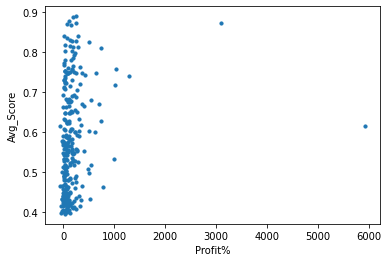

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_portfolio.plot(kind='scatter', x='Profit%', y='Avg_Score', s=10)

In [ ]:
#df_summary = df_portfolio[['Main_decile','Invested','Current_Value','Profit']].sum()
df_summary = df_portfolio.groupby(['Main_decile']).sum()
df_summary['Profit%'] = (df_summary['Profit']/df_summary['Invested'])*100
df_summary

,Start_Price,Final_Price,Quantity,Invested,Current_Value,Profit,Profit%,Avg_Score,Return
Main_decile,,,,,,,,,
Decile_25,"25,987.95","38,810.10","17,713.00","2,437,326.36","4,764,373.34","2,327,046.98",95.48,20.94,"3,601.90"
Decile_26,"36,167.94","57,601.25","28,343.00","2,427,768.47","4,686,688.12","2,258,919.64",93.05,23.15,"4,223.57"
Decile_27,"24,700.31","58,556.45","9,850.00","2,236,007.96","5,572,130.88","3,336,122.92",149.20,26.40,"6,353.13"
Decile_28,"54,294.33","109,565.85","7,268.00","2,367,647.38","8,346,748.18","5,979,100.81",252.53,29.37,"6,888.60"
Decile_29,"62,529.14","124,513.90","4,834.00","2,273,360.20","6,259,142.21","3,985,782.01",175.33,34.18,"6,365.99"
Decile_30,"119,188.62","248,611.63","6,366.00","2,357,773.97","9,166,983.45","6,809,209.48",288.80,40.78,"9,206.50"
Nifty,"10,792.50","17,203.95",4.00,"43,170.00","68,815.80","25,645.80",59.41,0.00,0.00


In [ ]:
df_trend_transposed = df_trend.transpose().reset_index()
#df_trend_transposed.columns[1] = 'Tikr'
df_trend_transposed.rename(columns={ df_trend_transposed.columns[0]: "Tikr" }, inplace = True)
df_trend_transposed = pd.merge(df_trend_transposed,df_portfolio[['Tikr','Quantity','Main_decile']], how='left',left_on=['Tikr'], right_on=['Tikr'])

# Taking the trend of Nifty into a different dataframe
df_trend_nifty = pd.DataFrame(df_trend_transposed.iloc[df_trend_transposed.shape[0]-1,:])
df_trend_nifty.columns = df_trend_nifty.iloc[0]
df_trend_nifty = df_trend_nifty.drop(df_trend_nifty.index[0])

# Multiplying the quantity by value
#df_trend_transposed = df_trend_transposed.iloc[:,1:-1] * df_trend_transposed.iloc[:,-1]
for col in range(len(df_trend_transposed.columns)):
    if col > 0 and col <  len(df_trend_transposed.columns) - 2:
        df_trend_transposed.iloc[:,col] = df_trend_transposed.iloc[:,col].multiply(df_trend_transposed['Quantity'], axis='index')

#df_trend_transposed = df_trend_transposed.iloc[:,1:-2].multiply(df_trend_transposed['Quantity'], axis='index')
# df_trend_transposed['Main_decile'][df_trend_transposed['Tikr'] == '^NSEI'] = 'Nifty'

df_trend_sum = df_trend_transposed.groupby(['Main_decile']).sum()
df_trend_sum = df_trend_sum.drop(['Quantity'],axis = 1)
df_trend_sum

,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-14,...,2021-12-17,2021-12-20,2021-12-21,2021-12-22,2021-12-23,2021-12-24,2021-12-27,2021-12-28,2021-12-29,2021-12-30
Main_decile,,,,,,,,,,,,,,,,,,,,,
Decile_25,"2,455,397.01","2,437,326.36","2,422,153.97","2,419,915.46","2,425,755.81","2,425,670.14","2,423,285.11","2,428,054.11","2,416,120.58","2,395,613.02",...,"4,684,131.52","4,517,646.00","4,576,218.06","4,655,417.64","4,689,739.15","4,657,764.31","4,660,593.83","4,720,573.11","4,738,803.87","4,764,373.34"
Decile_26,"2,460,573.55","2,427,768.47","2,411,344.88","2,416,235.16","2,419,857.11","2,417,945.86","2,415,659.59","2,423,408.28","2,418,072.15","2,412,271.85",...,"4,685,869.36","4,538,376.57","4,587,640.56","4,634,084.03","4,668,092.75","4,626,437.94","4,627,154.29","4,687,198.65","4,692,200.72","4,686,688.12"
Decile_27,"2,250,182.49","2,236,007.96","2,230,316.05","2,242,657.03","2,255,880.90","2,254,447.76","2,256,005.39","2,265,323.12","2,260,041.49","2,243,250.04",...,"5,411,269.10","5,279,590.86","5,333,652.48","5,399,704.75","5,483,220.77","5,454,001.99","5,489,726.33","5,523,138.64","5,557,891.64","5,572,130.88"
Decile_28,"2,378,329.59","2,367,647.38","2,351,281.17","2,358,763.46","2,357,793.88","2,354,830.37","2,348,836.42","2,360,969.85","2,357,783.61","2,350,180.81",...,"8,171,787.22","7,922,158.55","8,124,935.34","8,376,230.26","8,371,198.82","8,316,659.03","8,196,874.80","8,258,540.89","8,205,903.97","8,346,748.18"
Decile_29,"2,282,742.24","2,273,360.20","2,267,784.26","2,260,116.32","2,265,010.65","2,260,364.17","2,262,092.55","2,270,075.49","2,271,872.75","2,255,092.01",...,"6,096,070.09","5,968,316.02","6,005,808.39","6,098,395.94","6,141,086.55","6,102,566.35","6,103,663.15","6,181,396.67","6,225,263.79","6,259,142.21"
Decile_30,"2,378,820.54","2,357,773.97","2,347,786.37","2,349,945.68","2,349,493.78","2,348,129.31","2,356,082.77","2,361,491.01","2,359,169.35","2,362,848.03",...,"9,180,856.22","8,873,724.08","9,028,149.90","9,146,131.79","9,227,297.17","9,128,161.09","9,174,535.75","9,269,983.77","9,272,698.51","9,166,983.45"
Nifty,0.00,"43,170.00","42,689.00","42,909.40","43,087.20","43,208.60","43,420.60","43,286.40","43,179.80","42,950.40",...,"67,940.80","66,456.80","67,083.40","67,821.80","68,290.40","68,015.00","68,345.00","68,933.00","68,854.40","68,815.80"


In [ ]:
df_trend = df_trend_sum.transpose()
# First 
# row for Nifty is blank so we will assign it and then do the rest of the adjustments
df_trend.iloc[0,len(df_trend.columns)-1] = df_trend.iloc[1,len(df_trend.columns)-1]
df_trend
df_trend.to_clipboard()
df_normalized = df_trend.div(df_trend.iloc[0]).multiply(1000000)
df_normalized

Main_decile,Decile_25,Decile_26,Decile_27,Decile_28,Decile_29,Decile_30,Nifty
2019-01-01,"1,000,000.00","1,000,000.00","1,000,000.00","1,000,000.00","1,000,000.00","1,000,000.00","1,000,000.00"
2019-01-02,"992,640.44","986,667.71","993,700.72","995,508.52","995,890.01","991,152.52","1,000,000.00"
2019-01-03,"986,461.24","979,993.01","991,171.19","988,627.14","993,447.36","986,953.97","988,858.00"
2019-01-04,"985,549.57","981,980.47","996,655.62","991,773.17","990,088.27","987,861.69","993,963.36"
2019-01-07,"987,928.15","983,452.46","1,002,532.42","991,365.49","992,232.33","987,671.72","998,081.98"
...,...,...,...,...,...,...,...
2021-12-24,"1,896,949.57","1,880,227.45","2,423,804.30","3,496,848.83","2,673,348.85","3,837,263.44","1,575,515.40"
2021-12-27,"1,898,101.94","1,880,518.58","2,439,680.50","3,446,483.97","2,673,829.32","3,856,758.25","1,583,159.60"
2021-12-28,"1,922,529.47","1,904,921.17","2,454,529.21","3,472,412.29","2,707,882.02","3,896,882.35","1,596,780.17"
2021-12-29,"1,929,954.24","1,906,954.06","2,469,973.73","3,450,280.41","2,727,098.87","3,898,023.56","1,594,959.43"


<AxesSubplot:>

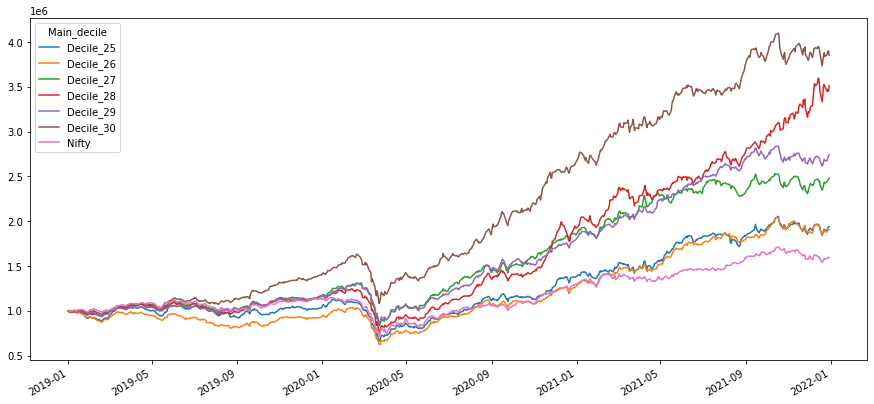

In [ ]:
df_normalized= df_normalized[df_normalized['Nifty'] != 0]
df_normalized.dropna().plot(figsize=(15,7))

In [386]:
df_summary
#Finish

,Start_Price,Final_Price,Quantity,Invested,Current_Value,Profit,Profit%,Avg_Score,Return
Main_decile,,,,,,,,,
Decile_25,"25,987.95","38,810.10","17,713.00","2,437,326.36","4,764,373.34","2,327,046.98",95.48,20.94,"3,601.90"
Decile_26,"36,167.94","57,601.25","28,343.00","2,427,768.47","4,686,688.12","2,258,919.64",93.05,23.15,"4,223.57"
Decile_27,"24,700.31","58,556.45","9,850.00","2,236,007.96","5,572,130.88","3,336,122.92",149.20,26.40,"6,353.13"
Decile_28,"54,294.33","109,565.85","7,268.00","2,367,647.38","8,346,748.18","5,979,100.81",252.53,29.37,"6,888.60"
Decile_29,"62,529.14","124,513.90","4,834.00","2,273,360.20","6,259,142.21","3,985,782.01",175.33,34.18,"6,365.99"
Decile_30,"119,188.62","248,611.63","6,366.00","2,357,773.97","9,166,983.45","6,809,209.48",288.80,40.78,"9,206.50"
Nifty,"10,792.50","17,203.95",4.00,"43,170.00","68,815.80","25,645.80",59.41,0.00,0.00


In [387]:
df_portfolio.to_clipboard()

In [388]:
df_summary.to_clipboard()